# ConsPortfolioModel: A Consumption-Savings model with risky assets

In [1]:
from copy import copy
from time import time

import matplotlib.pyplot as plt
import numpy as np

from HARK.ConsumptionSaving.ConsIndShockModel import init_lifecycle
from HARK.ConsumptionSaving.ConsPortfolioModel import (
    PortfolioConsumerType,
    init_portfolio,
)
from HARK.utilities import plot_funcs

In [2]:
# Make and solve an example portfolio choice consumer type
print("Now solving an example portfolio choice problem; this might take a moment...")
MyType = PortfolioConsumerType()
MyType.cycles = 0
t0 = time()
MyType.solve()
t1 = time()
MyType.cFunc = [MyType.solution[t].cFuncAdj for t in range(MyType.T_cycle)]
MyType.ShareFunc = [MyType.solution[t].ShareFuncAdj for t in range(MyType.T_cycle)]
print(
    "Solving an infinite horizon portfolio choice problem took "
    + str(t1 - t0)
    + " seconds."
)

Now solving an example portfolio choice problem; this might take a moment...


Solving an infinite horizon portfolio choice problem took 5.355165004730225 seconds.


Consumption function over market resources:


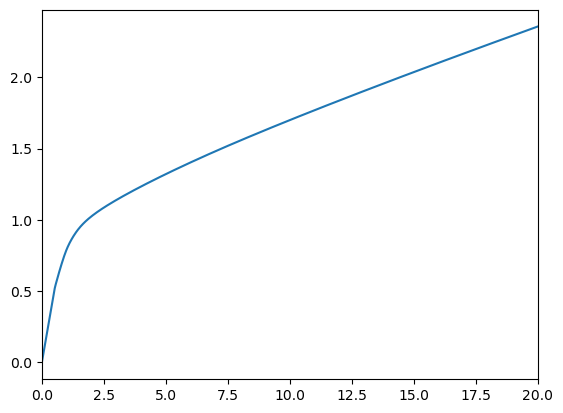

Risky asset share as a function of market resources:
Optimal (blue) versus Theoretical Limit (orange)


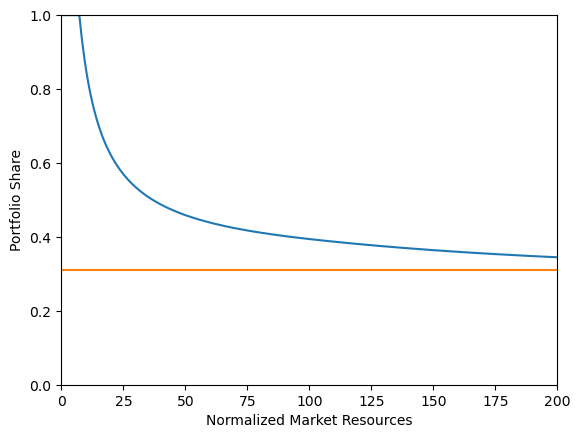

In [3]:
# Plot the consumption and risky-share functions
print("Consumption function over market resources:")
plot_funcs(MyType.cFunc[0], 0.0, 20.0)
print("Risky asset share as a function of market resources:")
print("Optimal (blue) versus Theoretical Limit (orange)")
plt.xlabel("Normalized Market Resources")
plt.ylabel("Portfolio Share")
plt.ylim(0.0, 1.0)
# Since we are using a discretization of the lognormal distribution,
# the limit is numerically computed and slightly different from
# the analytical limit obtained by Merton and Samuelson for infinite wealth
plot_funcs(
    [
        MyType.ShareFunc[0],
        lambda m: MyType.ShareLimit * np.ones_like(m),
    ],
    0.0,
    200.0,
)

In [4]:
# Now simulate this consumer type
MyType.track_vars = ["cNrm", "Share", "aNrm", "t_age"]
MyType.T_sim = 100
MyType.initialize_sim()
MyType.simulate()

{'cNrm': array([[0.90817813, 1.03234821, 0.93895877, ..., 0.97818197, 0.84936023,
         1.12020242],
        [0.94387464, 1.04618213, 0.96697859, ..., 1.03897301, 0.91091442,
         1.03919036],
        [1.03073799, 1.13701208, 1.0316563 , ..., 1.09427432, 1.00371896,
         0.99544467],
        ...,
        [1.32162527, 1.21076537, 1.01074883, ..., 1.0813753 , 1.10376194,
         1.12370596],
        [1.27953116, 1.24979895, 1.0246158 , ..., 1.07214199, 1.10681034,
         1.12995356],
        [1.34144268, 1.22379512, 1.01448791, ..., 1.09167141, 1.15069166,
         1.17400165]]),
 'Share': array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]),
 'aNrm': array([[0.45105775, 1.02451044, 0.55260976, ..., 0.71761922, 0.30438465,
         1.69655849],
        [0.57105533, 1.11746465, 0.6657

In [5]:
print("\n\n\n")
print("For derivation of the numerical limiting portfolio share")
print("as market resources approach infinity, see")
print(
    "http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/Portfolio-CRRA/"
)





For derivation of the numerical limiting portfolio share
as market resources approach infinity, see
http://www.econ2.jhu.edu/people/ccarroll/public/lecturenotes/AssetPricing/Portfolio-CRRA/


In [6]:
""
# Make another example type, but this one optimizes risky portfolio share only
# on the discrete grid of values implicitly chosen by RiskyCount, using explicit
# value maximization.
init_discrete_share = init_portfolio.copy()
init_discrete_share["DiscreteShareBool"] = True
# Have to actually construct value function for this to work
init_discrete_share["vFuncBool"] = True

In [7]:
# Make and solve a discrete portfolio choice consumer type
print("Now solving a discrete choice portfolio problem; this might take a minute...")
DiscreteType = PortfolioConsumerType(**init_discrete_share)
DiscreteType.cycles = 0
t0 = time()
DiscreteType.solve()
t1 = time()
DiscreteType.cFunc = [
    DiscreteType.solution[t].cFuncAdj for t in range(DiscreteType.T_cycle)
]
DiscreteType.ShareFunc = [
    DiscreteType.solution[t].ShareFuncAdj for t in range(DiscreteType.T_cycle)
]
print(
    "Solving an infinite horizon discrete portfolio choice problem took "
    + str(t1 - t0)
    + " seconds."
)

Now solving a discrete choice portfolio problem; this might take a minute...


Solving an infinite horizon discrete portfolio choice problem took 10.914522886276245 seconds.


Consumption function over market resources:


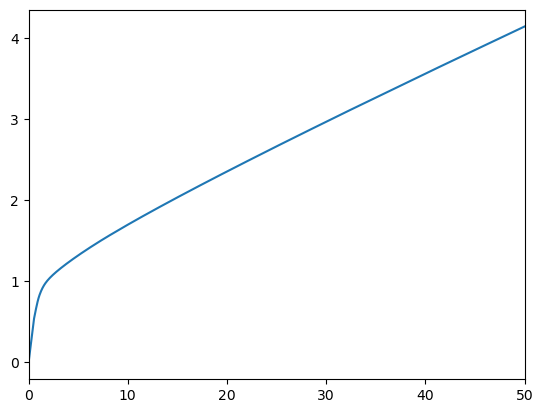

Risky asset share as a function of market resources:
Optimal (blue) versus Theoretical Limit (orange)


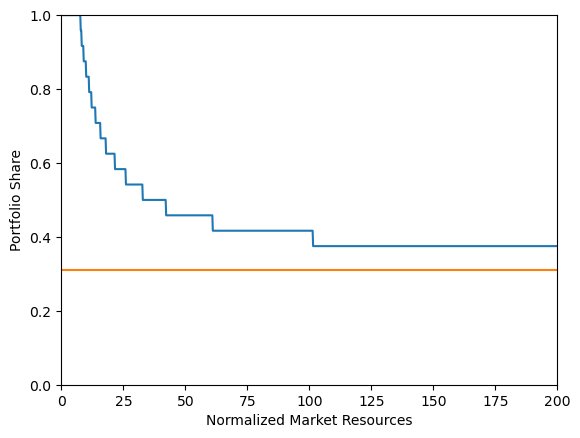

In [8]:
# Plot the consumption and risky-share functions
print("Consumption function over market resources:")
plot_funcs(DiscreteType.cFunc[0], 0.0, 50.0)
print("Risky asset share as a function of market resources:")
print("Optimal (blue) versus Theoretical Limit (orange)")
plt.xlabel("Normalized Market Resources")
plt.ylabel("Portfolio Share")
plt.ylim(0.0, 1.0)
# Since we are using a discretization of the lognormal distribution,
# the limit is numerically computed and slightly different from
# the analytical limit obtained by Merton and Samuelson for infinite wealth
plot_funcs(
    [DiscreteType.ShareFunc[0], lambda m: DiscreteType.ShareLimit * np.ones_like(m)],
    0.0,
    200.0,
)

In [9]:
print("\n\n\n")

In [10]:
""
# Make another example type, but this one can only update their risky portfolio
# share in any particular period with 15% probability.
init_sticky_share = init_portfolio.copy()
init_sticky_share["AdjustPrb"] = 0.15

In [11]:
# Make and solve a discrete portfolio choice consumer type
print(
    'Now solving a portfolio choice problem with "sticky" portfolio shares; this might take a moment...'
)
StickyType = PortfolioConsumerType(**init_sticky_share)
StickyType.cycles = 0
t0 = time()
StickyType.solve()
t1 = time()
StickyType.cFuncAdj = [
    StickyType.solution[t].cFuncAdj for t in range(StickyType.T_cycle)
]
StickyType.cFuncFxd = [
    StickyType.solution[t].cFuncFxd for t in range(StickyType.T_cycle)
]
StickyType.ShareFunc = [
    StickyType.solution[t].ShareFuncAdj for t in range(StickyType.T_cycle)
]
print(
    "Solving an infinite horizon sticky portfolio choice problem took "
    + str(t1 - t0)
    + " seconds."
)

Now solving a portfolio choice problem with "sticky" portfolio shares; this might take a moment...

Solving an infinite horizon sticky portfolio choice problem took 15.809079647064209 seconds.


Consumption function over market resources when the agent can adjust his portfolio:


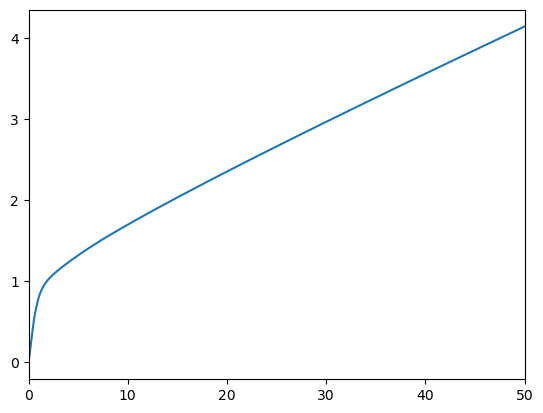

In [12]:
# Plot the consumption and risky-share functions
print(
    "Consumption function over market resources when the agent can adjust his portfolio:"
)
plot_funcs(StickyType.cFuncAdj[0], 0.0, 50.0)

Consumption function over market resources when the agent CAN'T adjust, by current share:


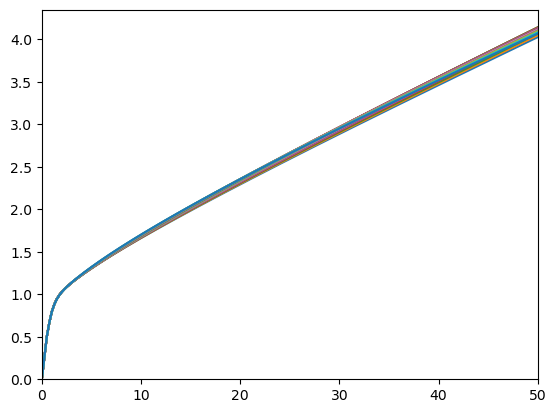

In [13]:
print(
    "Consumption function over market resources when the agent CAN'T adjust, by current share:"
)
M = np.linspace(0.0, 50.0, 200)
for s in np.linspace(0.0, 1.0, 21):
    C = StickyType.cFuncFxd[0](M, s * np.ones_like(M))
    plt.plot(M, C)
plt.xlim(0.0, 50.0)
plt.ylim(0.0, None)
plt.show()

Risky asset share function over market resources (when possible to adjust):
Optimal (blue) versus Theoretical Limit (orange)


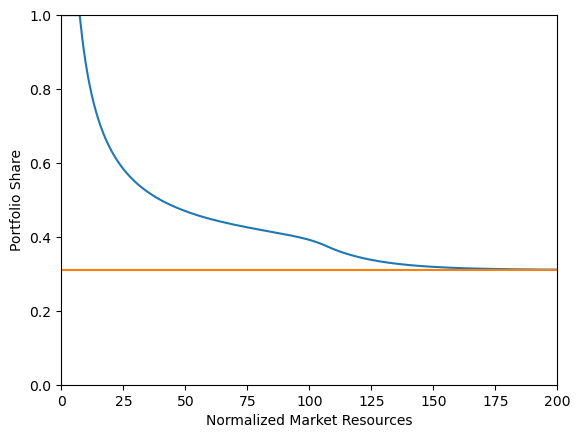

In [14]:
print("Risky asset share function over market resources (when possible to adjust):")
print("Optimal (blue) versus Theoretical Limit (orange)")
plt.xlabel("Normalized Market Resources")
plt.ylabel("Portfolio Share")
plt.ylim(0.0, 1.0)
plot_funcs(
    [StickyType.ShareFunc[0], lambda m: StickyType.ShareLimit * np.ones_like(m)],
    0.0,
    200.0,
)

In [15]:
""
# Make another example type, but this one has *age-varying* perceptions of risky asset returns.
# Begin by making a lifecycle dictionary, but adjusted for the portfolio choice model.
init_age_varying_risk_perceptions = copy(init_lifecycle)
init_age_varying_risk_perceptions["RiskyCount"] = init_portfolio["RiskyCount"]
init_age_varying_risk_perceptions["ShareCount"] = init_portfolio["ShareCount"]
init_age_varying_risk_perceptions["aXtraMax"] = init_portfolio["aXtraMax"]
init_age_varying_risk_perceptions["aXtraCount"] = init_portfolio["aXtraCount"]
init_age_varying_risk_perceptions["aXtraNestFac"] = init_portfolio["aXtraNestFac"]
init_age_varying_risk_perceptions["BoroCnstArt"] = init_portfolio["BoroCnstArt"]
init_age_varying_risk_perceptions["CRRA"] = init_portfolio["CRRA"]
init_age_varying_risk_perceptions["DiscFac"] = init_portfolio["DiscFac"]

In [16]:
init_age_varying_risk_perceptions["RiskyAvg"] = [1.08] * init_lifecycle["T_cycle"]
init_age_varying_risk_perceptions["RiskyStd"] = list(
    np.linspace(0.20, 0.30, init_lifecycle["T_cycle"])
)
init_age_varying_risk_perceptions["RiskyAvgTrue"] = 1.08
init_age_varying_risk_perceptions["RiskyStdTrue"] = 0.20
AgeVaryingRiskPercType = PortfolioConsumerType(**init_age_varying_risk_perceptions)
AgeVaryingRiskPercType.cycles = 1

In [17]:
# Solve the agent type with age-varying risk perceptions
# print('Now solving a portfolio choice problem with age-varying risk perceptions...')
t0 = time()
AgeVaryingRiskPercType.solve()
AgeVaryingRiskPercType.cFunc = [
    AgeVaryingRiskPercType.solution[t].cFuncAdj
    for t in range(AgeVaryingRiskPercType.T_cycle)
]
AgeVaryingRiskPercType.ShareFunc = [
    AgeVaryingRiskPercType.solution[t].ShareFuncAdj
    for t in range(AgeVaryingRiskPercType.T_cycle)
]
t1 = time()
print(
    "Solving a "
    + str(AgeVaryingRiskPercType.T_cycle)
    + " period portfolio choice problem with age-varying risk perceptions took "
    + str(t1 - t0)
    + " seconds."
)

Solving a 65 period portfolio choice problem with age-varying risk perceptions took 1.4531188011169434 seconds.


Consumption function over market resources in each lifecycle period:


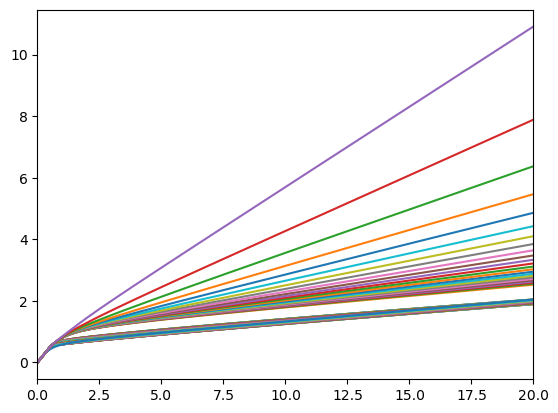

Risky asset share function over market resources in each lifecycle period:


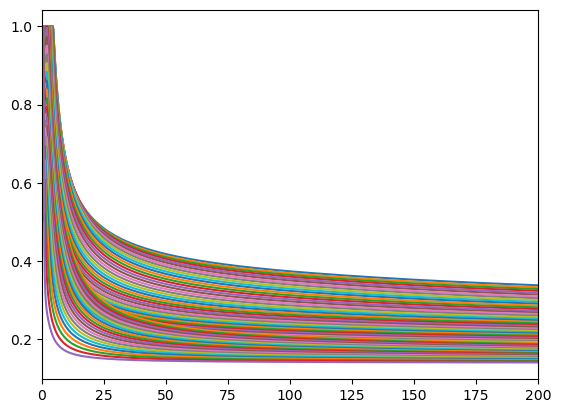

In [18]:
# Plot the consumption and risky-share functions
print("Consumption function over market resources in each lifecycle period:")
plot_funcs(AgeVaryingRiskPercType.cFunc, 0.0, 20.0)
print("Risky asset share function over market resources in each lifecycle period:")
plot_funcs(AgeVaryingRiskPercType.ShareFunc, 0.0, 200.0)

The code below tests the mathematical limits of the model.

In [19]:
# Create a grid of market resources for the plots
mMin = 0  # Minimum ratio of assets to income to plot
mMax = 5 * 1e2  # Maximum ratio of assets to income to plot
mPts = 1000  # Number of points to plot

eevalgrid = np.linspace(0, mMax, mPts)  # range of values of assets for the plot

# Number of points that will be used to approximate the risky distribution
risky_count_grid = [5, 50, 200]
# Plot by ages (time periods) at which to plot. We will use the default life-cycle calibration.
ages = [2, 4, 6, 8]

# Create lifecycle dictionary with portfolio choice parameters
merton_dict = copy(init_lifecycle)
merton_dict["RiskyCount"] = init_portfolio["RiskyCount"]
merton_dict["ShareCount"] = init_portfolio["ShareCount"]
merton_dict["aXtraMax"] = init_portfolio["aXtraMax"]
merton_dict["aXtraCount"] = init_portfolio["aXtraCount"]
merton_dict["aXtraNestFac"] = init_portfolio["aXtraNestFac"]
merton_dict["BoroCnstArt"] = init_portfolio["BoroCnstArt"]
merton_dict["CRRA"] = init_portfolio["CRRA"]
merton_dict["DiscFac"] = init_portfolio["DiscFac"]
merton_dict["RiskyAvgTrue"] = 1.08
merton_dict["RiskyStdTrue"] = 0.20


# Create a function to compute the Merton-Samuelson limiting portfolio share.
def RiskyShareMertSamLogNormal(RiskPrem, CRRA, RiskyVar):
    return RiskPrem / (CRRA * RiskyVar)

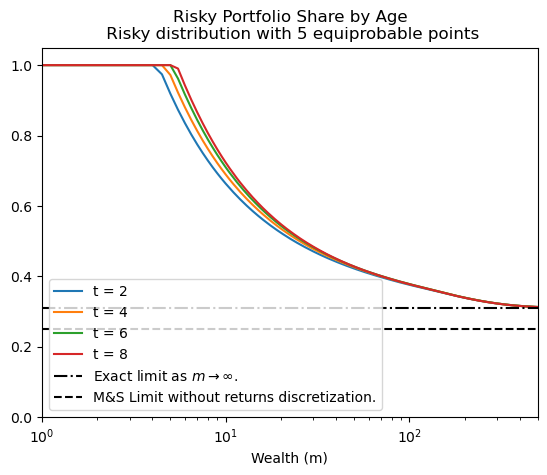

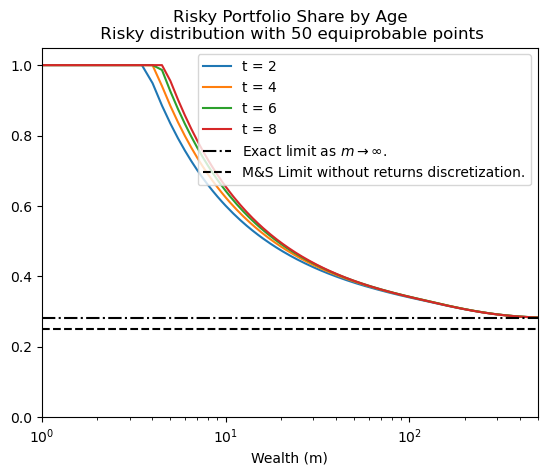

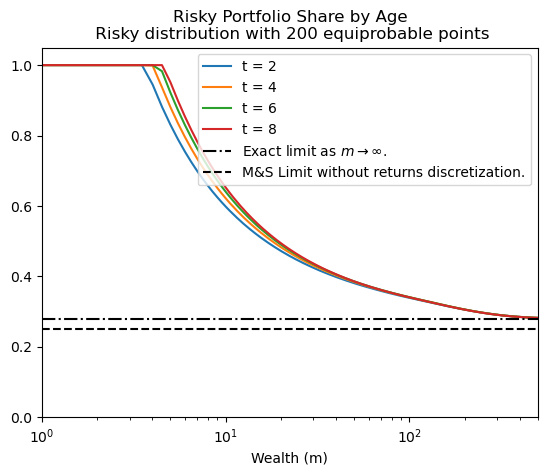

In [20]:
for rcount in risky_count_grid:

    # Create a new dictionary and replace the number of points that
    # approximate the risky return distribution

    # Create new dictionary copying the default
    merton_dict["RiskyCount"] = rcount

    # Create and solve agent
    agent = PortfolioConsumerType(**merton_dict)
    agent.solve()

    # Compute the analytical Merton-Samuelson limiting portfolio share
    RiskyVar = agent.RiskyStd**2
    RiskPrem = agent.RiskyAvg - agent.Rfree[0]
    MS_limit = RiskyShareMertSamLogNormal(RiskPrem, agent.CRRA, RiskyVar)

    # Now compute the limiting share numerically, using the approximated
    # distribution
    agent.update_ShareLimit()
    NU_limit = agent.ShareLimit

    plt.figure()
    for a in ages:
        plt.plot(
            eevalgrid, agent.solution[a].ShareFuncAdj(eevalgrid), label="t = %i" % (a)
        )

    plt.axhline(
        NU_limit, c="k", ls="-.", label="Exact limit as $m\\rightarrow \\infty$."
    )
    plt.axhline(
        MS_limit, c="k", ls="--", label="M&S Limit without returns discretization."
    )

    plt.ylim(0, 1.05)
    plt.xlim(eevalgrid[0] + 1, eevalgrid[-1])
    plt.xscale("log")
    plt.legend()
    plt.title(
        "Risky Portfolio Share by Age\n Risky distribution with {points} equiprobable points".format(
            points=rcount
        )
    )
    plt.xlabel("Wealth (m)")

    plt.ioff()
    plt.draw()